### Import Dependencies:

conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

conda install -c fastai fastai

In [4]:
from fastai.collab import *
from fastai.tabular.all import *

# Collaborative Filtering Book Recommendation System Using Deep Learning with LLM Integration

## Collaborative Filtering Model

### Import and Process the Book Data:

### Import Data:

In [5]:
import pandas as pd
ratings = pd.read_csv('Ratings.csv')
books = pd.read_csv('Books.csv', dtype={3: 'str'})

### Process the Data:

Merge ratings dataframe with the books dataframe and remove unnecessary columns:

In [6]:
ratings_books_df = ratings.merge(books, on='ISBN')
ratings_books_df.drop(columns=['ISBN', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
ratings_books_df.columns = ['user', 'rating', 'title']
ratings_books_df.head()

,user,rating,title
0,276725,0.0,Flesh Tones: A Novel
1,2313,5.0,Flesh Tones: A Novel
2,6543,0.0,Flesh Tones: A Novel
3,8680,5.0,Flesh Tones: A Novel
4,10314,9.0,Flesh Tones: A Novel


Filter the Data:

In [7]:
# Remove all ratings with 0.
ratings_books_df = ratings_books_df[ratings_books_df['rating'] > 0]

# Set thresholds for the number of ratings a user has given and the number of ratings a book has.
min_ratings_user = 100
min_ratings_book = 100

# Filters the dataframe to only include rows with users that have rated at least min_ratings_user books.
users_with_min_ratings = ratings_books_df.groupby('user').filter(lambda x: len(x) >= min_ratings_user)

# Filters the dataframe to only include movies with at least min_ratings_book ratings.
books_with_min_ratings = ratings_books_df.groupby('title').filter(lambda x: len(x) >= min_ratings_book)

# Filters the dataframe to include the correct data.
filtered_df = users_with_min_ratings[users_with_min_ratings['title'].isin(books_with_min_ratings['title'])]

filtered_df.head()

,user,rating,title
48,11676,10.0,The Notebook
53,23768,6.0,The Notebook
60,30711,6.0,The Notebook
103,158295,8.0,The Notebook
111,185233,7.0,The Notebook


### Create a DataLoader Using the Data:

In [8]:
# Dataloaders - Set seed to 42 for consistent results
dls = CollabDataLoaders.from_df(filtered_df, user_name='user', item_name='title', rating_name='rating', bs=64, seed=42)
dls.show_batch()

,user,title,rating
0,128835,Dreamcatcher,9.0
1,76151,A Painted House,10.0
2,11676,When the Wind Blows,10.0
3,46398,The Notebook,4.0
4,11676,The Bonesetter's Daughter,9.0
5,112001,The King of Torts,9.0
6,142524,Nickel and Dimed: On (Not) Getting By in America,8.0
7,147847,"Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson",9.0
8,11676,SHIPPING NEWS,3.0
9,21014,White Oleander : A Novel (Oprah's Book Club),7.0


### Create a deep learning model with 2 hidden layers for collaborative filtering:

Create the model:

In [9]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 10.5), layers=[100,50])

Find the optimal learning rate:

SuggestedLRs(minimum=0.04365158379077912, steep=0.0691830962896347)

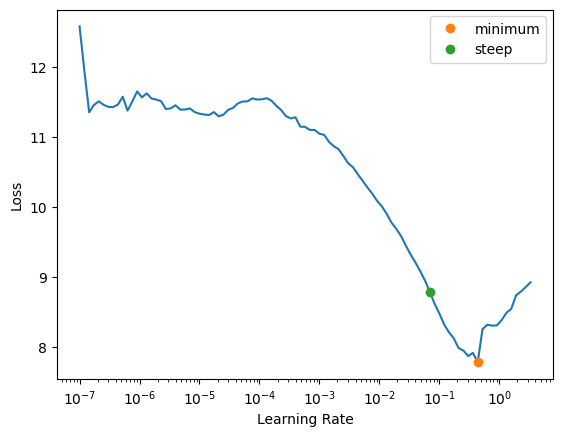

In [10]:
learn.lr_find(suggest_funcs=(minimum, steep))

Train the model:

In [11]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,10.061152,9.251115,00:00
1,7.837128,6.181627,00:00
2,5.556618,3.953169,00:00
3,3.885523,3.121849,00:00
4,2.772300,2.874272,00:00


### Predict user ratings for movies:

In [12]:
# User ID -- The user should already be in the training set or the new user
# should have initial rating values that are used to fine tune the model to include the user preferences for prediction
# Get a random user that exists in the training dataset.
user_id = filtered_df.sample(1)["user"].iloc[0]


# Creates a list of books that the user has not read.
rated_books = ratings_books_df[ratings_books_df['user'] == user_id]['title'].tolist()
all_books = ratings_books_df['title'].unique().tolist()
unrated_books = [book for book in all_books if book not in rated_books]

# Creates a corresponding list of the user_id, the same size of the list.
users = [user_id] * len(unrated_books)

# Places the two lists into a dataframe.
df = pd.DataFrame({'user': users, 'title': unrated_books})

# Creates a test dataloader.
dl = learn.dls.test_dl(df)

# Gets the rating predictions of each unrated book.
preds, _ = learn.get_preds(dl=dl)  # Unpack the tuple and ignore the second element

# Matches the list of titles and the resulting rating values then sorts and returns the top 10 books.
sorted_preds = sorted(zip(unrated_books, preds.squeeze()), key=lambda x: x[1], reverse=True)
top_recommendations = [pred[0] for pred in sorted_preds[:10]]

print(f"Top 10 book recommendations for user {user_id}:")
for book in top_recommendations:
    print(book)

Top 10 book recommendations for user 37712:
A Walk to Remember
Life of Pi
Into the Wild
Skipping Christmas
Harry Potter and the Goblet of Fire (Book 4)
The Bean Trees
Dreamcatcher
Stupid White Men ...and Other Sorry Excuses for the State of the Nation!
Divine Secrets of the Ya-Ya Sisterhood: A Novel
A Time to Kill


##

## LLM Setup - Llama3-8B

#### Huggingface Authentication

In [13]:
from huggingface_hub import login
login()

#### Check GPU Status

In [14]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


#### Install Transformers and accelerate

In [15]:
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-gb4sydj9
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-gb4sydj9
  Resolved https://github.com/huggingface/transformers to commit 73014b561d5f88d728e46a57d346f516fefe3f2d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.41.0.dev0-py3-none-any.whl size=9044069 sha256=fba9cea84134eafa23e72af9c5aeaf59f785730ae16d3d1c99135cade1f0bf4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-g2afq0fz/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#### Load the Llama3 Model

In [16]:
!pip install quanto
!pip install git+https://github.com/huggingface/accelerate.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install -i https://pypi.org/simple/ bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 832.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 3.9 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-elvjor0c
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-req-build-elvjor0c
  Resolved https://github.com/huggingface/accelerate.git to commit cd7df4117d92f660965d5f737364395b5693a535
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.30.0.dev0-py3-none-any.whl size=299917 sha256=b3b507345503a456923bedaaf9276a27f6637ea53c435015495f53000e495599
  Stored in directory: /tmp/pip-ephem-wheel-cache-z8jvhrir/wheels/9c/a3/1e/47368f9b6575655fe9ee1b6350cfa7d4b0befe66a35f8a8365
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing in

In [17]:
from transformers import AutoTokenizer, AutoModelForCausalLM, QuantoConfig, BitsAndBytesConfig
import torch

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

#### Pass Initial Message to Test Model

In [18]:
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Arrrr, shiver me timbers! Me name be Captain Chat, the scurviest pirate chatbot to ever sail the Seven Seas! I be here to swab the decks o' yer mind with me witty banter and me treasure trove o' pirate knowledge! So hoist the colors, me hearty, and let's set sail fer a swashbucklin' good time!


#

## LLM Recommendation Filtering

### Filtering Using the User's Liked Titles

#### Get the user's list of liked titles:

Return a dataframe containing all of the books the user has rated above the threshold:

In [19]:
user_id

37712

In [20]:
rating_threshold = 7
user_liked_df = filtered_df[(filtered_df["user"] == user_id) & (filtered_df["rating"] >= rating_threshold)]
user_liked_df

,user,rating,title
9903,37712,10.0,To Kill a Mockingbird
23148,37712,9.0,SHIPPING NEWS
26898,37712,8.0,Girl with a Pearl Earring
30338,37712,7.0,Angela's Ashes (MMP) : A Memoir
31395,37712,10.0,Bel Canto: A Novel
32354,37712,9.0,The Secret Life of Bees
46522,37712,7.0,Angels &amp; Demons
58627,37712,8.0,The Horse Whisperer
64821,37712,9.0,Snow Falling on Cedars
83884,37712,7.0,STONES FROM THE RIVER


Get the list of book titles from the user_df:

In [21]:
liked_titles = user_liked_df["title"].tolist()
liked_titles

['To Kill a Mockingbird',
 'SHIPPING NEWS',
 'Girl with a Pearl Earring',
 "Angela's Ashes (MMP) : A Memoir",
 'Bel Canto: A Novel',
 'The Secret Life of Bees',
 'Angels &amp; Demons',
 'The Horse Whisperer',
 'Snow Falling on Cedars',
 'STONES FROM THE RIVER',
 "Bridget Jones's Diary",
 'Prodigal Summer: A Novel',
 'Wicked: The Life and Times of the Wicked Witch of the West',
 'Jurassic Park']

#### Get the List of Initial Recommendations

Get a list of the top 30 books returned by the Collaborative Filtering Model:

In [22]:
top_k = 30
initial_recommendations = [pred[0] for pred in sorted_preds[:top_k]]
initial_recommendations

['A Walk to Remember',
 'Life of Pi',
 'Into the Wild',
 'Skipping Christmas',
 'Harry Potter and the Goblet of Fire (Book 4)',
 'The Bean Trees',
 'Dreamcatcher',
 'Stupid White Men ...and Other Sorry Excuses for the State of the Nation!',
 'Divine Secrets of the Ya-Ya Sisterhood: A Novel',
 'A Time to Kill',
 'Harry Potter and the Order of the Phoenix (Book 5)',
 '1984',
 "The Girls' Guide to Hunting and Fishing",
 'White Oleander : A Novel',
 'The Testament',
 'The Red Tent (Bestselling Backlist)',
 'The Hobbit : The Enchanting Prelude to The Lord of the Rings',
 "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
 'Chocolat',
 'A Prayer for Owen Meany',
 "The No. 1 Ladies' Detective Agency (Today Show Book Club #8)",
 'The Bridges of Madison County',
 'Icy Sparks',
 'The Joy Luck Club',
 'The Nanny Diaries: A Novel',
 "Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson",
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 'The Perfect Storm

#### Create the Prompt and Pass into the LLM for a Response

Create the Prompt:

In [23]:
message = {
    "role": "user",
    "content": f"Initial recommendations: {initial_recommendations}\nUser context: The user likes the following books: {liked_titles}\nPlease refine these recommendations to a list of 10 books based on the user's liked books and provide a brief explanation for each recommendation."
}

messages = [
    {
        "role": "system",
        "content": "You are an AI assistant that refines recommendations based on user preferences and item descriptions. Your task is to analyze the provided recommendations and user context, and generate a refined list of recommendations from the given larger list of books that matches the user's needs and preferences."
    },
    message
]

Pass into the Model and Print the Response:

In [ ]:
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=1024,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


#

### Filtering Using the User's Liked Titles and Ratings for Each Title

In [ ]:
user_liked_df

Create the list of books along with the user's ratings for eact title:

In [ ]:
user_context = []
for _, row in user_liked_df.iterrows():
    user_context.append(f"{row["title"]} (Rating: {row["rating"]})")

In [ ]:
user_context

Create the Message:

In [ ]:
message = {
    "role": "user",
    "content": f"Initial recommendations: {initial_recommendations}\nUser context: The user likes the following books with their ratings: {', '.join(user_context)}\nPlease refine these recommendations to a list of 10 books based on the user's liked books and ratings, and provide a brief explanation for each recommendation."
}

messages = [
    {
        "role": "system",
        "content": "You are an AI assistant that refines recommendations based on user preferences and item descriptions. Your task is to analyze the provided recommendations and user context, and generate a refined list of recommendations from the given larger list of books that matches the user's needs and preferences."
    },
    message
]

Pass into the LLM:

In [ ]:
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=1024,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

## Calculating the Average Proportion of Recommendation Overlap

### Average Proportion of Recommendation Overlap for CF vs CF+LLM (Titles only)

Get list of users:

In [ ]:
users_list = filtered_df["user"].unique().tolist()

Calculate Average Proportion Overlap:

In [ ]:
total_overlap = 0

for user in users_list:
    # User ID -- The user should already be in the training set or the new user
    # should have initial rating values that are used to fine tune the model to include the user preferences for prediction
    user_id = user

    # Creates a list of books that the user has not read.
    rated_books = ratings_books_df[ratings_books_df['user'] == user_id]['title'].tolist()
    all_books = ratings_books_df['title'].unique().tolist()
    unrated_books = [book for book in all_books if book not in rated_books]

    # Creates a corresponding list of the user_id, the same size of the list.
    users = [user_id] * len(unrated_books)

    # Places the two lists into a dataframe.
    df = pd.DataFrame({'user': users, 'title': unrated_books})

    # Creates a test dataloader.
    dl = learn.dls.test_dl(df)

    # Gets the rating predictions of each unrated book.
    preds, _ = learn.get_preds(dl=dl)  # Unpack the tuple and ignore the second element

    # Matches the list of titles and the resulting rating values then sorts and returns the top 10 books.
    sorted_preds = sorted(zip(unrated_books, preds.squeeze()), key=lambda x: x[1], reverse=True)
    initial_recommendations = [pred[0] for pred in sorted_preds[:30]]

    rating_threshold = 7
    user_liked_df = filtered_df[(filtered_df["user"] == user_id) & (filtered_df["rating"] >= rating_threshold)]
    liked_titles = user_liked_df["title"].tolist()

    message = {
        "role": "user",
        "content": f"Initial recommendations: {initial_recommendations}\nUser context: The user likes the following books: {liked_titles}\nPlease refine these recommendations to a list of 10 books based on the user's liked books and provide a brief explanation for each recommendation."
    }

    messages = [
        {
            "role": "system",
            "content": "You are an AI assistant that refines recommendations based on user preferences and item descriptions. Your task is to analyze the provided recommendations and user context, and generate a refined list of recommendations from the given larger list of books that matches the user's needs and preferences. The list of books returned must be from the given list."
        },
        message
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=1024,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )
    response = outputs[0][input_ids.shape[-1]:]
    LLM_recommendations = tokenizer.decode(response, skip_special_tokens=True)
    print(LLM_recommendations)

    for initial_recommendation in initial_recommendations[:10]:
        if initial_recommendation in LLM_recommendations:
            total_overlap += 1
            print(initial_recommendation)

    nl = '\n'
    print(f"{nl}Liked Books: {nl}{liked_titles}")
    print(f"Overlap calculated for user: {user}{nl}")

average = total_overlap / len(users_list)
print(average)

### Average Proportion of Recommendation Overlap for CF vs CF+LLM (Titles and Good Ratings)

In [ ]:
total_overlap = 0

for user in users_list:
    # User ID -- The user should already be in the training set or the new user
    # should have initial rating values that are used to fine tune the model to include the user preferences for prediction
    user_id = user

    # Creates a list of books that the user has not read.
    rated_books = ratings_books_df[ratings_books_df['user'] == user_id]['title'].tolist()
    all_books = ratings_books_df['title'].unique().tolist()
    unrated_books = [book for book in all_books if book not in rated_books]

    # Creates a corresponding list of the user_id, the same size of the list.
    users = [user_id] * len(unrated_books)

    # Places the two lists into a dataframe.
    df = pd.DataFrame({'user': users, 'title': unrated_books})

    # Creates a test dataloader.
    dl = learn.dls.test_dl(df)

    # Gets the rating predictions of each unrated book.
    preds, _ = learn.get_preds(dl=dl)  # Unpack the tuple and ignore the second element

    # Matches the list of titles and the resulting rating values then sorts and returns the top 10 books.
    sorted_preds = sorted(zip(unrated_books, preds.squeeze()), key=lambda x: x[1], reverse=True)
    initial_recommendations = [pred[0] for pred in sorted_preds[:30]]

    rating_threshold = 7
    user_liked_df = filtered_df[(filtered_df["user"] == user_id) & (filtered_df["rating"] >= rating_threshold)]
    user_context = []
    for _, row in user_liked_df.iterrows():
        user_context.append(f"{row["title"]} (Rating: {row["rating"]})")
    liked_titles = user_liked_df["title"].tolist()

    message = {
        "role": "user",
        "content": f"Initial recommendations: {initial_recommendations}\nUser context: The user likes the following books with their ratings: {', '.join(user_context)}\nPlease refine these recommendations to a list of 10 books based on the user's liked books and ratings, and provide a brief explanation for each recommendation."
    }

    messages = [
        {
            "role": "system",
            "content": "You are an AI assistant that refines recommendations based on user preferences and item descriptions. Your task is to analyze the provided recommendations and user context, and generate a refined list of recommendations from the given larger list of books that matches the user's needs and preferences."
        },
        message
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=1024,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )
    response = outputs[0][input_ids.shape[-1]:]
    LLM_recommendations = tokenizer.decode(response, skip_special_tokens=True)

    for initial_recommendation in initial_recommendations[:10]:
        if initial_recommendation in LLM_recommendations:
            total_overlap += 1
            print(initial_recommendation)

    nl = '\n'
    print(f"{nl}Liked Books: {nl}{liked_titles}")
    print(f"Overlap calculated for user: {user}{nl}")

average = total_overlap / len(users_list)
print(average)

### Average Proportion of Recommendation Overlap for CF vs CF+LLM (Titles with Good and Bad Ratings)

In [ ]:
total_overlap = 0

for user in users_list:
    # User ID -- The user should already be in the training set or the new user
    # should have initial rating values that are used to fine tune the model to include the user preferences for prediction
    user_id = user

    # Creates a list of books that the user has not read.
    rated_books = ratings_books_df[ratings_books_df['user'] == user_id]['title'].tolist()
    all_books = ratings_books_df['title'].unique().tolist()
    unrated_books = [book for book in all_books if book not in rated_books]

    # Creates a corresponding list of the user_id, the same size of the list.
    users = [user_id] * len(unrated_books)

    # Places the two lists into a dataframe.
    df = pd.DataFrame({'user': users, 'title': unrated_books})

    # Creates a test dataloader.
    dl = learn.dls.test_dl(df)

    # Gets the rating predictions of each unrated book.
    preds, _ = learn.get_preds(dl=dl)  # Unpack the tuple and ignore the second element

    # Matches the list of titles and the resulting rating values then sorts and returns the top 10 books.
    sorted_preds = sorted(zip(unrated_books, preds.squeeze()), key=lambda x: x[1], reverse=True)
    initial_recommendations = [pred[0] for pred in sorted_preds[:30]]

    rating_threshold = 7
    user_liked_df = filtered_df[(filtered_df["user"] == user_id) & (filtered_df["rating"] >= rating_threshold)]
    user_liked_context = []
    for _, row in user_liked_df.iterrows():
        user_liked_context.append(f"{row["title"]} (Rating: {row["rating"]})")
    liked_titles = user_liked_df["title"].tolist()

    rating_threshold = 5
    user_disliked_df = filtered_df[(filtered_df["user"] == user_id) & (filtered_df["rating"] < rating_threshold)]
    user_disliked_context = []
    for _, row in user_disliked_df.iterrows():
        user_disliked_context.append(f"{row["title"]} (Rating: {row["rating"]})")
    disliked_titles = user_disliked_df["title"].tolist()


    message = {
        "role": "user",
        "content": f"Initial recommendations: {initial_recommendations}\nUser context: The user likes the following books with their ratings: {', '.join(user_liked_context)} and dislikes the following books with their ratings: {', '.join(user_disliked_context)} \nPlease refine these recommendations to a list of 10 books based on the user's liked books and ratings, and provide a brief explanation for each recommendation."
    }

    messages = [
        {
            "role": "system",
            "content": "You are an AI assistant that refines recommendations based on user preferences and item descriptions. Your task is to analyze the provided recommendations and user context, and generate a refined list of recommendations from the given larger list of books that matches the user's needs and preferences."
        },
        message
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=1024,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )
    response = outputs[0][input_ids.shape[-1]:]
    LLM_recommendations = tokenizer.decode(response, skip_special_tokens=True)

    for initial_recommendation in initial_recommendations[:10]:
        if initial_recommendation in LLM_recommendations:
            total_overlap += 1
            print(initial_recommendation)

    nl = '\n'
    print(f"{nl}Liked Books: {nl}{liked_titles}")
    print(f"Overlap calculated for user: {user}{nl}")

average = total_overlap / len(users_list)
print(average)

In [ ]:
cf_llm_titles = 3.007125890736342
cf_llm_titles_liked = 2.34916864608076
cf_llm_titles_liked_disliked = 2.3776722090261284

import matplotlib.pyplot as plt

# Data
data = {
    'CF-LLM Titles': cf_llm_titles / 10,
    'CF-LLM Titles with Liked Books': cf_llm_titles_liked / 10,
    'CF-LLM Titles with Liked and Disliked Books': cf_llm_titles_liked_disliked / 10,
}

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(data.keys(), data.values())

# Customize the chart
ax.set_title('Average Recommendation Overlap Proportion Between CF and CF+LLM Models')
ax.set_xlabel('Models')
ax.set_ylabel('Average Overlap Proportion')
ax.tick_params(axis='x', rotation=45)

# Display the chart
plt.tight_layout()
plt.show()

### Average Proportion of Recommendation Overlap for CF vs CF+LLM (Titles only) (Top 50)

In [ ]:
total_overlap = 0

for idx, user in enumerate(users_list):
    # User ID -- The user should already be in the training set or the new user
    # should have initial rating values that are used to fine tune the model to include the user preferences for prediction
    user_id = user

    # Creates a list of books that the user has not read.
    rated_books = ratings_books_df[ratings_books_df['user'] == user_id]['title'].tolist()
    all_books = ratings_books_df['title'].unique().tolist()
    unrated_books = [book for book in all_books if book not in rated_books]

    # Creates a corresponding list of the user_id, the same size of the list.
    users = [user_id] * len(unrated_books)

    # Places the two lists into a dataframe.
    df = pd.DataFrame({'user': users, 'title': unrated_books})

    # Creates a test dataloader.
    dl = learn.dls.test_dl(df)

    # Gets the rating predictions of each unrated book.
    preds, _ = learn.get_preds(dl=dl)  # Unpack the tuple and ignore the second element

    # Matches the list of titles and the resulting rating values then sorts and returns the top 10 books.
    sorted_preds = sorted(zip(unrated_books, preds.squeeze()), key=lambda x: x[1], reverse=True)
    initial_recommendations = [pred[0] for pred in sorted_preds[:50]]

    rating_threshold = 7
    user_liked_df = filtered_df[(filtered_df["user"] == user_id) & (filtered_df["rating"] >= rating_threshold)]
    liked_titles = user_liked_df["title"].tolist()

    message = {
        "role": "user",
        "content": f"Initial recommendations: {initial_recommendations}\nUser context: The user likes the following books: {liked_titles}\nPlease refine these recommendations to a list of 10 books based on the user's liked books and provide a brief explanation for each recommendation."
    }

    messages = [
        {
            "role": "system",
            "content": "You are an AI assistant that refines recommendations based on user preferences and item descriptions. Your task is to analyze the provided recommendations and user context, and generate a refined list of recommendations from the given larger list of books that matches the user's needs and preferences. The list of books returned must be from the given list."
        },
        message
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=1024,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )
    response = outputs[0][input_ids.shape[-1]:]
    LLM_recommendations = tokenizer.decode(response, skip_special_tokens=True)
    print(LLM_recommendations)

    for initial_recommendation in initial_recommendations[:10]:
        if initial_recommendation in LLM_recommendations:
            total_overlap += 1
            print(initial_recommendation)

    nl = '\n'
    print(f"{nl}Liked Books: {nl}{liked_titles}")
    print(f"Overlap calculated for user: {user}{nl}With index of {idx}{nl}")

average = total_overlap / len(users_list)
print(average)
cf_llm_titles_50 = average

### Average Proportion of Recommendation Overlap for CF vs CF+LLM (Titles and Good Ratings)

In [ ]:
total_overlap = 0

for idx,user in enumerate(users_list):
    # User ID -- The user should already be in the training set or the new user
    # should have initial rating values that are used to fine tune the model to include the user preferences for prediction
    user_id = user

    # Creates a list of books that the user has not read.
    rated_books = ratings_books_df[ratings_books_df['user'] == user_id]['title'].tolist()
    all_books = ratings_books_df['title'].unique().tolist()
    unrated_books = [book for book in all_books if book not in rated_books]

    # Creates a corresponding list of the user_id, the same size of the list.
    users = [user_id] * len(unrated_books)

    # Places the two lists into a dataframe.
    df = pd.DataFrame({'user': users, 'title': unrated_books})

    # Creates a test dataloader.
    dl = learn.dls.test_dl(df)

    # Gets the rating predictions of each unrated book.
    preds, _ = learn.get_preds(dl=dl)  # Unpack the tuple and ignore the second element

    # Matches the list of titles and the resulting rating values then sorts and returns the top 10 books.
    sorted_preds = sorted(zip(unrated_books, preds.squeeze()), key=lambda x: x[1], reverse=True)
    initial_recommendations = [pred[0] for pred in sorted_preds[:50]]

    rating_threshold = 7
    user_liked_df = filtered_df[(filtered_df["user"] == user_id) & (filtered_df["rating"] >= rating_threshold)]
    user_context = []
    for _, row in user_liked_df.iterrows():
        user_context.append(f"{row["title"]} (Rating: {row["rating"]})")
    liked_titles = user_liked_df["title"].tolist()

    message = {
        "role": "user",
        "content": f"Initial recommendations: {initial_recommendations}\nUser context: The user likes the following books with their ratings: {', '.join(user_context)}\nPlease refine these recommendations to a list of 10 books based on the user's liked books and ratings, and provide a brief explanation for each recommendation."
    }

    messages = [
        {
            "role": "system",
            "content": "You are an AI assistant that refines recommendations based on user preferences and item descriptions. Your task is to analyze the provided recommendations and user context, and generate a refined list of recommendations from the given larger list of books that matches the user's needs and preferences."
        },
        message
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=1024,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )
    response = outputs[0][input_ids.shape[-1]:]
    LLM_recommendations = tokenizer.decode(response, skip_special_tokens=True)

    for initial_recommendation in initial_recommendations[:10]:
        if initial_recommendation in LLM_recommendations:
            total_overlap += 1
            print(initial_recommendation)

    nl = '\n'
    print(f"{nl}Liked Books: {nl}{liked_titles}")
    print(f"Overlap calculated for user: {user}{nl}With index of {idx}{nl}")

average = total_overlap / len(users_list)
print(average)
cf_llm_titles_liked = average

### Average Proportion of Recommendation Overlap for CF vs CF+LLM (Titles with Good and Bad Ratings)

In [ ]:
total_overlap = 0

for idx,user in enumerate(users_list):
    # User ID -- The user should already be in the training set or the new user
    # should have initial rating values that are used to fine tune the model to include the user preferences for prediction
    user_id = user

    # Creates a list of books that the user has not read.
    rated_books = ratings_books_df[ratings_books_df['user'] == user_id]['title'].tolist()
    all_books = ratings_books_df['title'].unique().tolist()
    unrated_books = [book for book in all_books if book not in rated_books]

    # Creates a corresponding list of the user_id, the same size of the list.
    users = [user_id] * len(unrated_books)

    # Places the two lists into a dataframe.
    df = pd.DataFrame({'user': users, 'title': unrated_books})

    # Creates a test dataloader.
    dl = learn.dls.test_dl(df)

    # Gets the rating predictions of each unrated book.
    preds, _ = learn.get_preds(dl=dl)  # Unpack the tuple and ignore the second element

    # Matches the list of titles and the resulting rating values then sorts and returns the top 10 books.
    sorted_preds = sorted(zip(unrated_books, preds.squeeze()), key=lambda x: x[1], reverse=True)
    initial_recommendations = [pred[0] for pred in sorted_preds[:50]]

    rating_threshold = 7
    user_liked_df = filtered_df[(filtered_df["user"] == user_id) & (filtered_df["rating"] >= rating_threshold)]
    user_liked_context = []
    for _, row in user_liked_df.iterrows():
        user_liked_context.append(f"{row["title"]} (Rating: {row["rating"]})")
    liked_titles = user_liked_df["title"].tolist()

    rating_threshold = 5
    user_disliked_df = filtered_df[(filtered_df["user"] == user_id) & (filtered_df["rating"] < rating_threshold)]
    user_disliked_context = []
    for _, row in user_disliked_df.iterrows():
        user_disliked_context.append(f"{row["title"]} (Rating: {row["rating"]})")
    disliked_titles = user_disliked_df["title"].tolist()


    message = {
        "role": "user",
        "content": f"Initial recommendations: {initial_recommendations}\nUser context: The user likes the following books with their ratings: {', '.join(user_liked_context)} and dislikes the following books with their ratings: {', '.join(user_disliked_context)} \nPlease refine these recommendations to a list of 10 books based on the user's liked books and ratings, and provide a brief explanation for each recommendation."
    }

    messages = [
        {
            "role": "system",
            "content": "You are an AI assistant that refines recommendations based on user preferences and item descriptions. Your task is to analyze the provided recommendations and user context, and generate a refined list of recommendations from the given larger list of books that matches the user's needs and preferences."
        },
        message
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=1024,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )
    response = outputs[0][input_ids.shape[-1]:]
    LLM_recommendations = tokenizer.decode(response, skip_special_tokens=True)

    for initial_recommendation in initial_recommendations[:10]:
        if initial_recommendation in LLM_recommendations:
            total_overlap += 1
            print(initial_recommendation)

    nl = '\n'
    print(f"{nl}Liked Books: {nl}{liked_titles}")
    print(f"Overlap calculated for user: {user}{nl}With index of {idx}{nl}")

average = total_overlap / len(users_list)
print(average)
cf_llm_titles_disliked = average